In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
#matplotlib defaults
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'



%matplotlib inline

In [2]:
#plot mag vs 
obs=pd.read_csv(wisps.OUTPUT_FILES+'/observation_log.csv')
obs.columns=[x.lower() for x in obs.columns]#.lower()
def add_survey(pointing):
    if pointing.startswith('par'):
        return 'wisps'
    else:
        return '3d-hst'
obs_df=obs.drop(['unnamed: 0'], axis=1).drop_duplicates('pointing').reset_index()
obs_df['survey']=obs.pointing.apply(add_survey)

In [3]:
obs_df=obs_df.drop(['index'], axis=1)

In [4]:
#obs_df.to_latex(wisps.LIBRARIES+'/observations.tex', longtable=True, index=False)

In [5]:
phot=pd.read_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='all_phot_spec_data')
fphot=wisps.Annotator.reformat_table(phot)

In [6]:
stars=wisps.Annotator.reformat_table(pd.read_hdf(wisps.COMBINED_PHOTO_SPECTRO_FILE, key='stars'))

In [7]:
stars=stars[stars.snr1>=3.0]

In [8]:
len(stars)

46370

In [9]:
cutphot=fphot[((fphot.snr1>=3.0))]

In [10]:
import astropy.stats.bayesian_blocks as bb

In [11]:
#edgesf160 =bb(cutphot.F160.replace(np.inf, np.nan).dropna(), fitness='events', p0=0.01)
#edges140= bb(cutphot.F140.replace(np.inf, np.nan).dropna(), fitness='events', p0=0.01)
#edges110= bb(cutphot.F110.replace(np.inf, np.nan).dropna(), fitness='events', p0=0.01)

In [12]:
wispsph=fphot[fphot.grism_id.str.startswith('par')]
hst3d=fphot[~ fphot.grism_id.str.startswith('par')]

In [13]:
len(phot), len(wispsph), len(hst3d), len(stars),len(stars[stars.f_test>0.5])

(270436, 194437, 75999, 46370, 1154)

In [14]:
starswisp=stars[stars.grism_id.str.startswith('par')]
#starshst3d=stars[(~ stars.grism_id.str.startswith('par')) & (stars.star_flags !=2.) ]
starshst3d=stars[(~ stars.grism_id.str.startswith('par')) &  (stars.F160<25.)]
#starshst3d=stars[(~ stars.grism_id.str.startswith('par'))]

In [15]:
#stars.F160<25.

In [16]:
from matplotlib.ticker import MultipleLocator

In [17]:
wispsph.F160.dropna().values

array([19.441, 25.273, 23.898, ..., 23.617, 22.62 , 22.44 ])

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


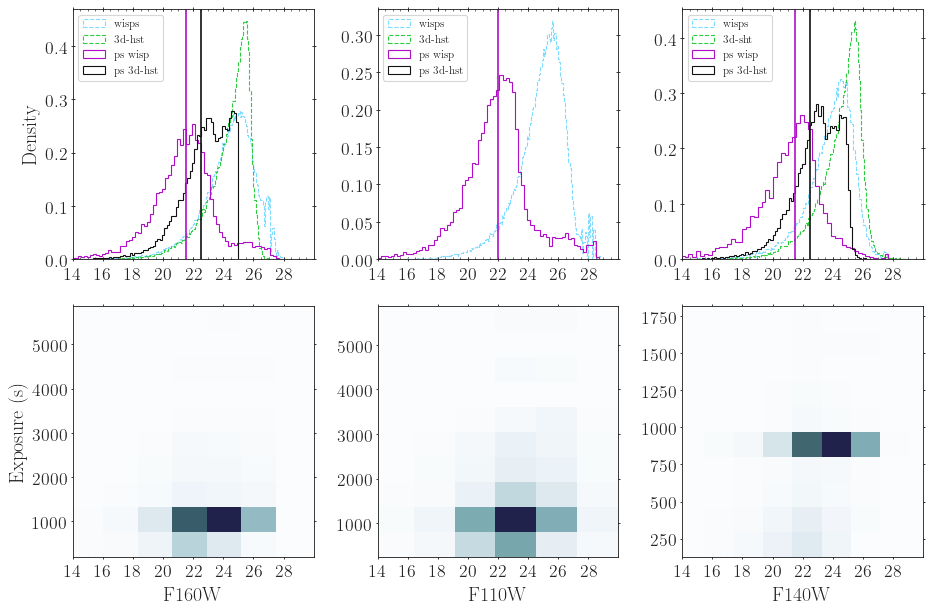

In [18]:
fig, ax=plt.subplots(ncols=3, nrows=2, figsize=(6*2, 4*2))
##top
h=ax[0][0].hist(wispsph.F160.dropna().values, label='wisps', bins='auto', color='#7FDBFF', density=True, histtype='step', linestyle='--')
h=ax[0][1].hist(wispsph.F110.dropna().values,  label='wisps', bins='auto', color='#7FDBFF', density=True, histtype='step', linestyle='--')
h=ax[0][2].hist(wispsph.F140.replace(np.inf, np.nan).dropna().values,   label='wisps', bins='auto', color='#7FDBFF', density=True, histtype='step' , linestyle='--')
#h=cutphot.F140.replace(np.inf, np.nan).dropna().plot(kind='hist', ax=ax[0][2], bins='auto',label='F140', color='#7FDBFF', density=True)

h=ax[0][0].hist(hst3d.F160.dropna().values,  label='3d-hst', bins='auto', color='#2ECC40', density=True, histtype='step', linestyle='--')
h=ax[0][1].hist(hst3d.F110.dropna().values,  label='3d-hst', bins='auto', color='#2ECC40', density=True, histtype='step',  linestyle='--')
h=ax[0][2].hist(hst3d.F140.replace(np.inf, np.nan).dropna().values,  label='3d-sht', bins='auto', color='#2ECC40', density=True, histtype='step',  linestyle='--')

h=ax[0][0].hist(starswisp.F160.dropna().values,  label='ps wisp', bins='auto', color='#B10DC9', density=True, histtype='step')
h=ax[0][1].hist(starswisp.F110.dropna().values,   label='ps wisp', bins='auto', color='#B10DC9', density=True, histtype='step')
h=ax[0][2].hist(starswisp.F140.replace(np.inf, np.nan).dropna().values,   label='ps wisp', bins='auto',  color='#B10DC9', density=True, histtype='step')

h=ax[0][0].hist(starshst3d.F160.dropna().values,  label='ps 3d-hst', bins='auto', color='#111111', density=True, histtype='step')
h=ax[0][1].hist(starshst3d.F110.dropna().values,   label='ps 3d-hst', bins='auto', color='#111111', density=True, histtype='step')
h=ax[0][2].hist(starshst3d.F140.replace(np.inf, np.nan).dropna().values,   label='ps 3d-hst', bins='auto',  color='#111111', density=True, histtype='step')


#bayesian blocks
#H2 = ax[0][0].hist(cutphot.F160.replace(np.inf, np.nan).dropna(), bins=edgesf160, color='#111111',  density=True, lw =2, histtype='step')
#H2 = ax[0][1].hist(cutphot.F110.replace(np.inf, np.nan).dropna(), bins=edges110, color='#111111',  density=True, lw =2, histtype='step')
#H2 =ax[0][2].hist(cutphot.F140.replace(np.inf, np.nan).dropna(), bins=edges140, color='#111111',  density=True, lw =2, histtype='step')

ax[0][0].axvline(21.5, color='#B10DC9', linestyle='-')
ax[0][0].axvline(22.5, color='#111111', linestyle='-')

ax[0][1].axvline(22.0, color='#B10DC9', linestyle='-')
#ax[0][1].axvline(23,  color='#111111')


ax[0][2].axvline(21.5,color='#B10DC9', linestyle='-')
ax[0][2].axvline(22.5, color='#111111', linestyle='-')





#ax[1][0].scatter( cutphot.F160, cutphot.exposure, marker=',', alpha=0.1, s=50)
#sns.kdeplot( cutphot.F160, cutphot.exposure, ax=ax[1][0])
df=cutphot[['F160', 'exposure']].replace(np.inf, np.nan).dropna()
ax[1][0].hist2d(df.F160.values, df.exposure.values, cmap=wisps.MYCOLORMAP)

df=cutphot[['F110', 'exposure']].replace(np.inf, np.nan).dropna()
ax[1][1].hist2d(df.F110.values, df.exposure.values, cmap=wisps.MYCOLORMAP)

df=cutphot[['F140', 'exposure']].replace(np.inf, np.nan).dropna()
ax[1][2].hist2d(df.F140.values, df.exposure.values, cmap=wisps.MYCOLORMAP)

#sns.kdeplot( df.F160, df.exposure, ax=ax[1][0], shade=True)
#ax[1][1].scatter( cutphot.F110, cutphot.exposure, marker=',', alpha=0.1, s=50)
#ax[1][2].scatter( cutphot.F140, cutphot.exposure, marker=',', alpha=0.1, s=50)



ax[1][0].set_xlabel('F160W', fontsize=18)
ax[1][1].set_xlabel('F110W', fontsize=18)
ax[1][2].set_xlabel('F140W', fontsize=18)

ax[1][0].set_ylabel('Exposure (s)', fontsize=18)
ax[0][0].set_ylabel('Density', fontsize=18)
#ax[1][2].set_ylabel('Exposure (s)', fontsize=18)

for a in np.concatenate(ax):
    a.set_xticks(np.arange(14, 30, 2.0))
    a.set_xlim([14, 30])
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    a.xaxis.set_minor_locator
    a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    ml = MultipleLocator(.5)
    a.xaxis.set_minor_locator(ml)


#ax[0][0].set_ylim([0., 0.35])
#ax[0][1].set_ylim([0., 0.30])
#ax[0][2].set_ylim([0., 0.35])


ax[0][0].legend(loc='upper left', fontsize=10)
ax[0][1].legend(loc='upper left', fontsize=10)
ax[0][2].legend(loc='upper left', fontsize=10)
    
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/mag_limit.pdf')

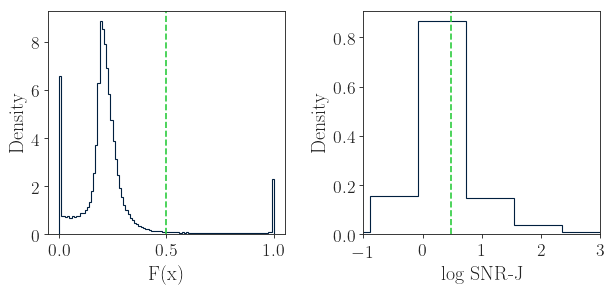

In [19]:
fig, (ax, ax1)=plt.subplots(figsize=(8, 4), ncols=2, sharey=False)
h=ax.hist(phot.f_test, bins=100, color='#001f3f', density=True, histtype='step')

ax.axvline(.5, color='#2ECC40', linestyle='--')
ax.set_xlabel('F(x)', fontsize=18)
ax.set_ylabel('Density', fontsize=18)


h=ax1.hist(phot.snr1.apply(np.log10), bins=100, color='#001f3f', density=True, histtype='step')

ax1.axvline(np.log10(3.), color='#2ECC40', linestyle='--')
ax1.set_xlabel('log SNR-J', fontsize=18)
ax1.set_ylabel('Density', fontsize=18)
ax1.set_xlim([-1., 3.])
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/f_test_snr_distr.pdf')

In [20]:
mag_limits={'wisps':{'F110W':[22.0, 18.0], 'F140W':[21.5, 16.0], 'F160W':[21.5, 16.0] }, 
            'hst3d':{'F140W':[22.5, 16.0], 'F160W':[22.5, 16.0] }}

In [21]:
import pickle
#save the random forest
output_file=wisps.OUTPUT_FILES+'/magnitude_cutoff.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(mag_limits,file)


In [22]:
unrl=stars[(~ stars.grism_id.str.startswith('par')) & (stars.star_flags ==2.) ]
unrl3=stars[(~ stars.grism_id.str.startswith('par')) & (stars.star_flags !=2.) ]

AttributeError: 'DataFrame' object has no attribute 'star_flags'

In [ ]:
unrl2=unrl[unrl['snr1']<10.]
unrl3=unrl3[unrl3['snr1']<10.]

In [ ]:
len(unrl2), len(unrl)

In [ ]:
import seaborn as sns

In [ ]:
fig, ax=plt.subplots()
plt.scatter(unrl2.snr1.values, unrl2.F140.values, marker='+', alpha=0.3, label='star\_flag=2')
plt.scatter(unrl3.snr2.values, unrl3.F140.values, marker='+', alpha=0.3, label='star\_flag=1')
plt.axvline(3., c='k')
plt.legend(prop={'size': 16})

plt.xlabel('SNR')
plt.ylabel('F140W')

In [ ]:
P=plt.hist(unrl2.F140.values, normed=True, histtype='step', label='star\_flag=2')
P=plt.hist(unrl3.F140.values, normed=True, histtype='step', label='star\_flag=1')
plt.xlabel('F140W')
plt.legend()

In [ ]:
sus=['GOODSS-01-G141_45889',  'GOODSS-04-G141_17402', 'GOODSS-28-G141_10859', 'GOODSN-24-G141_21552']

In [ ]:
sus=[x.lower() for x in sus]

In [ ]:
wisps.Annotator.reformat_table((phot[['snr1', 'F140', 'F110', 'F160', 'star_flags', 'spt', 'grism_id']])[phot.grism_id.str.lower().isin(sus)])

In [ ]:
phot[phot.grism_id.str.startswith('goodss')].star_flags.plot(kind='hist')